# Section 1: Importing The Libraries

In [0]:
import numpy as np
import math
import re # regular expression
import pandas as pd
from bs4 import BeautifulSoup #Text pre-processing
from google.colab import drive
import zipfile
import seaborn as sns #Data visualization
import string
import spacy as sp
import random
import matplotlib.pyplot as plt

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

TensorFlow 2.x selected.


'2.1.0'

In [0]:
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Section 2: Pre processing

###Dataset upload

In [0]:
#get the database from Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Extract the file in the root folder of Colab
path = '/content/drive/My Drive/trainingandtestdata.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

In [0]:
cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']

In [0]:
train_data = pd.read_csv('/content/trainingandtestdata/train.csv', header=None,
                         names=cols, engine='python', encoding='latin1')

In [0]:
train_data.shape

(1600000, 6)

In [0]:
train_data.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [0]:
train_data.sentiment.unique()

array([0, 4])

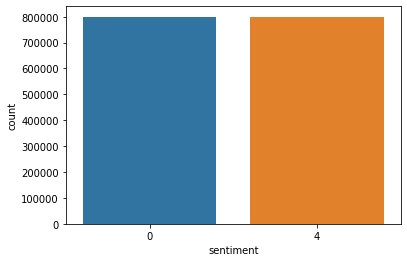

In [0]:
sns.countplot(train_data.sentiment)

In [0]:
test_data = pd.read_csv('/content/trainingandtestdata/test.csv',
                        header=None,
                        names=cols,
                        engine='python',
                        encoding='latin1')

In [0]:
test_data.shape

(498, 6)

In [0]:
test_data.head()

,sentiment,id,date,query,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [0]:
test_data.sentiment.unique()

array([4, 0, 2])

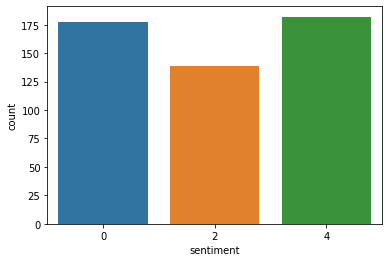

In [0]:
sns.countplot(test_data.sentiment)

### Cleaning

In [0]:
data = train_data

In [0]:
data.drop(['id', 'date', 'query', 'user'], axis=1, inplace=True)

In [0]:
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [0]:
x = data.iloc[:, 1].values

In [0]:
x

array(["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
       "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
       '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
       ..., 'Are you ready for your MoJo Makeover? Ask me for details ',
       'Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur ',
       'happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H '],
      dtype=object)

In [0]:
x.shape

(1600000,)

In [0]:
type(x)

numpy.ndarray

In [0]:
y = data.iloc[:, 0].values
y

array([0, 0, 0, ..., 4, 4, 4])

Because of the size of the dataset, it'd take some hours to train. Will only be used 25% of the dataset. 

In [0]:
from sklearn.model_selection import train_test_split
x, _, y, _ = train_test_split(x, y, test_size=0.75, stratify = y)# stratify in this case is used to split the same quantity of positive and negative classes

In [0]:
x.shape

(400000,)

In [0]:
y.shape

(400000,)

In [0]:
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array([0, 4]), array([200000, 200000]))

In [0]:
#remove stop words (words that may be removed without affecting the classification of the sentiment), using the "spacy" library
nlp = sp.load('en')
stop_words = sp.lang.en.STOP_WORDS

In [0]:
def stop_words_removal(tweet):
  tweet = tweet.lower()
  document = nlp(tweet)

  words = []

  for token in document:
    words.append(token.text)
  
  words = [word for word in words if word not in stop_words and word not in string.punctuation]
  words = ' '.join([str(element) for element in words])
  return words

In [0]:
def clean_tweets(tweet, partialClean=False):
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)#removing the username
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)#removing the URL
  if not partialClean:
    tweet = re.sub(r"[^A-Za-z.!?]", ' ', tweet)#removing special characters
    tweet = re.sub(r" +", ' ', tweet)
    tweet = stop_words_removal(tweet)
  else:
    tweet = re.sub("-", ' ', tweet)#removing the dashes
    tweet = tweet.lower()
    tweet = re.sub(r" +", ' ', tweet)
  return tweet.strip()

In [0]:
text = "@switchfoot http://twitpic.com/2ylzl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"

In [0]:
clean_text = clean_tweets(text)
partial_cleaned_text = clean_tweets(text, True)
print(clean_text+'\n')
print(partial_cleaned_text+'\n')



awww s bummer shoulda got david carr day d

awww, that's a bummer. you shoulda got david carr of third day to do it. ;d



In [0]:
data_clean = [clean_tweets(tweet) for tweet in x]
dt_clean = pd.DataFrame(data_clean)

In [0]:
data_partially_clean = [clean_tweets(tweet) for tweet in x]

In [0]:
for _ in range(10):
  print(data_clean[random.randint(0, len(data_clean)-1)])

love remember year oh fest went taco bell
misses download
wish leonidas says hi
kimbalicious thank
thanks
chayla gave great advice
mate united states got lot australia b lol
d noticed difference keith s photos d want ......
best friends leaving months came goodbye party fun sad
nope friday


In [0]:
for _ in range(10):
  print(data_partially_clean[random.randint(0, len(data_partially_clean)-1)])

ouch sounds painful
sitting waiting carpool
think actually possibly falling asleep
know
miss steppy working bad
cried school cos math results hate crying public got st class english
trying survive abusive relationship
stephanie hahah stealing thunder
worries hide delicious candies bought u tempted munch xx
need faces mad frowns m m wastin fabric ...


In [0]:
data_labels = y

In [0]:
data_labels[data_labels == 4] = 1
data_labels

array([1, 1, 1, ..., 0, 0, 0])

In [0]:
np.unique(data_labels)

array([0, 1])

### Tokenization

In [0]:
tokenizer_data_clean = tfds.features.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16, )
tokenizer_dataPartially_clean = tfds.features.text.SubwordTextEncoder.build_from_corpus(data_partially_clean, target_vocab_size=2**16, )

In [0]:
tokenizer_data_clean.vocab_size

70755

In [0]:
tokenizer_dataPartially_clean.vocab_size

70755

In [0]:
ids = tokenizer_data_clean.encode('i am happy')
ids

[299, 4562, 376]

In [0]:
phrase = tokenizer_data_clean.decode(ids)
phrase

'i am happy'

In [0]:
#create a list of sentence tokens from cleaned data
data_clean_inputs = [tokenizer_data_clean.encode(sentence) for sentence in data_clean]

In [0]:
#create a list of sentence tokens from partially cleaned data
data_part_clean_inputs = [tokenizer_dataPartially_clean.encode(sentence) for sentence in data_clean]

In [0]:
for _ in range(10):
  print(data_clean_inputs[random.randint(0, len(data_clean_inputs)-1)])

[8, 136, 53, 2159, 943, 75, 15629]
[348, 297, 64, 4488]
[67823]
[23, 11, 62, 930, 4, 77, 182, 634, 1838, 12, 9194]
[175, 2196, 2, 13002, 12084, 4087, 56, 113, 1625]
[204, 12, 36873]
[1, 5, 25410, 2, 51, 8780, 23052, 51743, 70599]
[1241, 4672, 245, 2886, 48, 2, 30, 43]
[1, 172, 760, 259, 7345, 23548]
[577, 561, 60, 39]


In [0]:
for _ in range(10):
  print(data_part_clean_inputs[random.randint(0, len(data_part_clean_inputs)-1)])

[2579, 2792, 76, 2579, 19, 5235, 5263, 5407, 207, 32, 1348]
[1071, 24, 778, 28480]
[265, 1571, 367, 37]
[24, 33, 2, 8342]
[30, 574, 293, 542, 10811, 52, 3, 161, 345]
[6333, 57, 70, 38, 52, 3, 16, 209, 356, 103, 2956]
[66, 1111, 36, 4332, 1436, 41, 1111, 12, 601]
[14065, 2276, 5352, 766, 1848, 331, 45, 19036]
[50835, 55951, 5154, 6, 5311, 34405, 70531, 6249, 36831, 68677, 2490, 41869, 52848, 70531, 2405, 2597, 6, 1871]
[3225, 54422, 70531, 528, 7748, 127, 3, 628, 35476, 18407, 8443, 6836]


### Padding

Pad the sentences, so all get the same size

In [0]:
max_len_clean = max([len(sentence) for sentence in data_clean_inputs])
max_len_clean

52

In [0]:
max_len_part_clean = max([len(sentence) for sentence in data_part_clean_inputs])
max_len_part_clean

52

In [0]:
#pad the sentences with 0s on the right
data_clean_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_clean_inputs, value=0, padding='post', maxlen=max_len_clean)
data_part_clean_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_part_clean_inputs, value=0, padding='post', maxlen=max_len_part_clean)

In [0]:
for _ in range(10):
  print(data_clean_inputs[random.randint(0, len(data_clean_inputs)-1)])

[  215  1440   267  5030    94   498    23  6495 28959 70531  8734     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
[ 296  758 1688  251  184   43    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
[2713 1783    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
[2269 4544   79 2284 5014    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0

In [0]:
for _ in range(10):
  print(data_part_clean_inputs[random.randint(0, len(data_part_clean_inputs)-1)])

[ 2524 15104  2570    26 11145 35087 70531  8090 17698  3505 29098    32
   117  4828     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
[  22   79  364   22  167    4    3   58 5829    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
[ 47  26 350  43   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  84    2   10  635   30    2 1167  245  178  132    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   

### Split the dataset into train and test

In [0]:
train_inputs_cl, test_inputs_cl, train_labels_cl, test_labels_cl = train_test_split(data_clean_inputs, data_labels, test_size=0.3, stratify = data_labels)

In [0]:
train_inputs_cl[0]

array([2879,  562, 2267,  367,  366,  107,   45, 1248, 2795,    4, 1447,
         15,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [0]:
train_inputs_cl.shape

(280000, 52)

In [0]:
train_labels_cl.shape

(280000,)

In [0]:
test_inputs_cl.shape

(120000, 52)

In [0]:
test_labels_cl.shape

(120000,)

In [0]:
train_inputs_pc, test_inputs_pc, train_labels_pc, test_labels_pc = train_test_split(data_part_clean_inputs, data_labels, test_size=0.3, stratify = data_labels)

In [0]:
train_inputs_pc[0]

array([129, 185,  98,   5, 132,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      dtype=int32)

In [0]:
train_inputs_pc.shape

(280000, 52)

In [0]:
train_labels_pc.shape

(280000,)

In [0]:
test_inputs_pc.shape

(120000, 52)

In [0]:
test_labels_pc.shape

(120000,)

# Section 3: Building the Model

In [0]:
class DCNN(tf.keras.Model):
  def __init__(self,
               vocab_size,
               emb_dim=128,
               nb_filters=50,
               ffn_units=512,
               nb_classes=2,
               dropout_rate=0.1,
               training=True,
               name="dcnn"):
    '''
    :param vocab_size: Size of the vocabulary
    :param emb_dim: Dimension of the embedding -- emb_dim=128
    :param nb_filters: Number of convolutional -- filters nb_filters=50
    :param ffn_units: Number of Feedforward Networks units -- ffn_units=512
    :param nb_classes: Number of classes -- nb_classes=2
    :param dropout_rate: Dropout rate, helps to avoid overfitting -- dropout_rate=0.1
    :param training: training=False
    :param name: name="dcnn"
    '''
    super(DCNN, self).__init__(name=name)

    #Convolution Layers
    self.embedding = layers.Embedding(vocab_size, emb_dim)

    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')

    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')

    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')

    self.pool = layers.GlobalMaxPool1D()

    #Dense Network
    self.dense_1 = layers.Dense(units = ffn_units)

    self.dropout = layers.Dropout(rate = dropout_rate)
    if nb_classes == 2:
      #we want, in this case, return only one correct classification
      self.last_dense = layers.Dense(units=1, activation='sigmoid')
    else:
      #Softmax activation function returns the probability of all classes 
      self.last_dense = layers.Dense(units=nb_classes, activation='softmax')

    
  def call(self, inputs, training):
    x = self.embedding(inputs)
    x_1 = self.bigram(x)
    x_1 = self.pool(x_1)

    x_2 = self.trigram(x)
    x_2 = self.pool(x_2)

    x_3 = self.fourgram(x)
    x_3 = self.pool(x_3)

    merged = tf.concat([x_1, x_2, x_3], axis=-1)
    merged = self.dense_1(merged)
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output

# Section 4: Training

### Parameters Setup

Parameters were tested in advance and performed the best results among the tested.

In [0]:
vocab_size_cl = tokenizer_data_clean.vocab_size
vocab_size_pc = tokenizer_dataPartially_clean.vocab_size
emb_dim = 200
nb_filters = 100
ffn_units = 256
batch_size=64
nb_classes = 2 #set function returns the number of unique values in train_labels
dropout_rate = 0.2
nb_epochs = 15

### Training Totally Cleaned Data

In [0]:
dcnn = DCNN(vocab_size=vocab_size_cl, emb_dim=emb_dim,
            nb_filters=nb_filters, ffn_units=ffn_units,
            nb_classes=nb_classes, dropout_rate=dropout_rate)

In [0]:
if nb_classes == 2:
  dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
  dcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
checkpoint_path = '/content/drive/My Drive/Checkpoints/dt_clean'
ckpt = tf.train.Checkpoint(dcnn=dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored')

In [0]:
history = dcnn.fit(train_inputs_cl, 
                   train_labels_cl,
                   batch_size=batch_size,
                   epochs = nb_epochs,
                   verbose = 1,
                   validation_split= 0.10)
ckpt_manager.save()

Train on 252000 samples, validate on 28000 samples
Epoch 1/15
252000/252000 [==============================] - 529s 2ms/sample - loss: 0.4954 - accuracy: 0.7571 - val_loss: 0.4704 - val_accuracy: 0.7746
Epoch 2/15
252000/252000 [==============================] - 527s 2ms/sample - loss: 0.3732 - accuracy: 0.8354 - val_loss: 0.4906 - val_accuracy: 0.7679
Epoch 3/15
252000/252000 [==============================] - 528s 2ms/sample - loss: 0.2127 - accuracy: 0.9140 - val_loss: 0.6510 - val_accuracy: 0.7441
Epoch 4/15
252000/252000 [==============================] - 533s 2ms/sample - loss: 0.1152 - accuracy: 0.9546 - val_loss: 0.8332 - val_accuracy: 0.7279
Epoch 5/15
252000/252000 [==============================] - 536s 2ms/sample - loss: 0.0797 - accuracy: 0.9684 - val_loss: 0.9761 - val_accuracy: 0.7262
Epoch 6/15
252000/252000 [==============================] - 531s 2ms/sample - loss: 0.0621 - accuracy: 0.9753 - val_loss: 1.1105 - val_accuracy: 0.7299
Epoch 7/15
252000/252000 [===========

### Training Partially Cleaned Data

In [0]:
dcnn2 = DCNN(vocab_size=vocab_size_pc, emb_dim=emb_dim,
            nb_filters=nb_filters, ffn_units=ffn_units,
            nb_classes=nb_classes, dropout_rate=dropout_rate)

In [0]:
if nb_classes == 2:
  dcnn2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
  dcnn2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
checkpoint_path2 = '/content/drive/My Drive/Checkpoints/dt_partially_clean'
ckpt2 = tf.train.Checkpoint(dcnn=dcnn2)
ckpt_manager2 = tf.train.CheckpointManager(ckpt2, checkpoint_path2, max_to_keep=5)
if ckpt_manager2.latest_checkpoint:
  ckpt.restore(ckpt_manager2.latest_checkpoint)
  print('Latest checkpoint restored')

In [0]:
history2 = dcnn2.fit(train_inputs_pc, 
                   train_labels_pc,
                   batch_size=batch_size,
                   epochs = nb_epochs,
                   verbose = 1,
                   validation_split= 0.10)
ckpt_manager.save()

Train on 252000 samples, validate on 28000 samples
Epoch 1/15
252000/252000 [==============================] - 533s 2ms/sample - loss: 0.4953 - accuracy: 0.7582 - val_loss: 0.4692 - val_accuracy: 0.7743
Epoch 2/15
252000/252000 [==============================] - 533s 2ms/sample - loss: 0.3721 - accuracy: 0.8368 - val_loss: 0.4958 - val_accuracy: 0.7650
Epoch 3/15
252000/252000 [==============================] - 539s 2ms/sample - loss: 0.2145 - accuracy: 0.9128 - val_loss: 0.6308 - val_accuracy: 0.7507
Epoch 4/15
252000/252000 [==============================] - 533s 2ms/sample - loss: 0.1184 - accuracy: 0.9535 - val_loss: 0.8619 - val_accuracy: 0.7354
Epoch 5/15
252000/252000 [==============================] - 534s 2ms/sample - loss: 0.0812 - accuracy: 0.9679 - val_loss: 1.0021 - val_accuracy: 0.7343
Epoch 6/15
252000/252000 [==============================] - 542s 2ms/sample - loss: 0.0632 - accuracy: 0.9751 - val_loss: 1.0357 - val_accuracy: 0.7291
Epoch 7/15
252000/252000 [===========

# Section 5: Evaluate The Model

### Evaluation - Cleaned Data

In [0]:
results = dcnn.evaluate(test_inputs_cl, test_labels_cl, batch_size=batch_size)
print(results)

120000/120000 [==============================] - 5s 42us/sample - loss: 1.6598 - accuracy: 0.7205
[1.6597781845887503, 0.7205]


In [0]:
y_pred_test = dcnn.predict(test_inputs_cl)

In [0]:
y_pred_test

array([[9.9999022e-01],
       [9.9756938e-01],
       [8.0242693e-01],
       ...,
       [9.1149221e-04],
       [5.5515188e-01],
       [1.1601086e-01]], dtype=float32)

In [0]:
y_pred_test = (y_pred_test > 0.5)

In [0]:
y_pred_test

array([[ True],
       [ True],
       [ True],
       ...,
       [False],
       [ True],
       [False]])

In [0]:
test_labels_cl

array([1, 1, 0, ..., 1, 0, 0])

Confusion Matrix for the Cleanead Data

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels_cl, y_pred_test)
cm

array([[46322, 13678],
       [19862, 40138]])

**In the confusion matrix above it is possible to see that:** 
*   46.322 was correctly classified for the Negative class and 13.678 wrong classifications;
*   For the Positive class, it has a correct classification of 40.138 instances and 19.882 wrong.
*   Total of 86.640 (72,05%) correct classifications for both classes, and 33.540 (27,95%) wrong classifications.

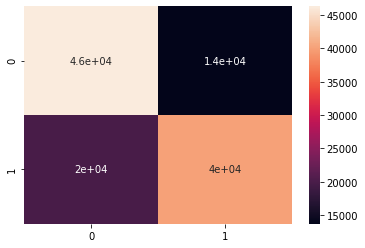

In [0]:
# Confusion Matrix
sns.heatmap(cm, annot=True)

In [0]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

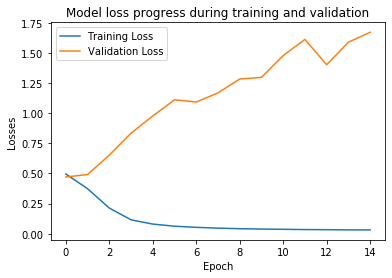

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend(['Training Loss', 'Validation Loss'])

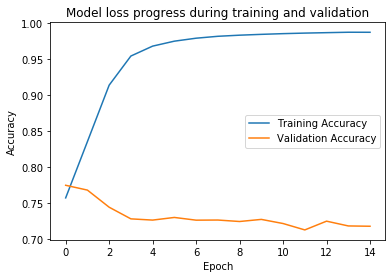

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

As seen in the plot above, the training accuracy has a high increase in the first four epochs, going from 0,7571 on the first epoch to 0.9684 on the fifth epoch. While the validation accuracy degraded over the epochs, having a noticed decrease in the first 3 epochs. From epoch three onwards until epoch 9 it had a small decrease. Between 9 and 11 there was a higher decrease but on the next epoch increased back and then decreased slowly again. 
It's normal the validation accuracy be smaller than training accuracy, otherwise, my model could be underfitting. However, the validation accuracy can not get too small, because it could mean overfitting. In this model, training and validation accuracy seems to be acceptable

### Evaluation - Partially Cleaned Data

In [0]:
results2 = dcnn2.evaluate(test_inputs_pc, test_labels_pc, batch_size=batch_size)
print(results)

120000/120000 [==============================] - 5s 43us/sample - loss: 1.7405 - accuracy: 0.7220
[1.6597781845887503, 0.7205]


In [0]:
y_pred_test2 = dcnn.predict(test_inputs_pc)

In [0]:
y_pred_test2

array([[5.854679e-10],
       [9.671047e-01],
       [9.999144e-01],
       ...,
       [7.703902e-01],
       [9.999958e-01],
       [8.595380e-06]], dtype=float32)

In [0]:
y_pred_test2 = (y_pred_test2 > 0.5)

In [0]:
y_pred_test2

array([[False],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [False]])

In [0]:
test_labels_pc

array([0, 1, 0, ..., 0, 1, 0])

Confusion Matrix for the Partially Cleaned Data

In [0]:
cm2 = confusion_matrix(test_labels_pc, y_pred_test2)
cm2

array([[54399,  5601],
       [ 7674, 52326]])

**In the confusion matrix above it is possible to see that:** 
*   54.399 was correctly classified for the Negative class and 5.601 wrong classifications;
*   For the Positive class, it has a correct classification of 52.326 instances and 7.674 wrong.
*   Total of 106.725 (88,94%) correct classifications for both classes, and 13.275 (11,06%) wrong classifications.

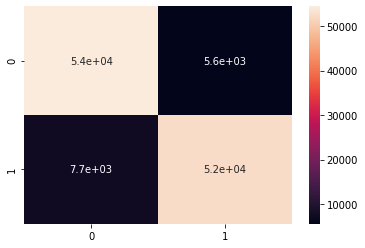

In [0]:
# Confusion Matrix
sns.heatmap(cm2, annot=True)

The partially cleaned data, as seen in the confusion matrixes, performed better on the tests. This may be due to over-cleaning. Maybe punctuation makes easier for the model to classify the emotions.

In [0]:
history2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Graphs Evaluation Of Both Training

#### Plot of Cleaned Data accuracy and loss progress during the training and validation.

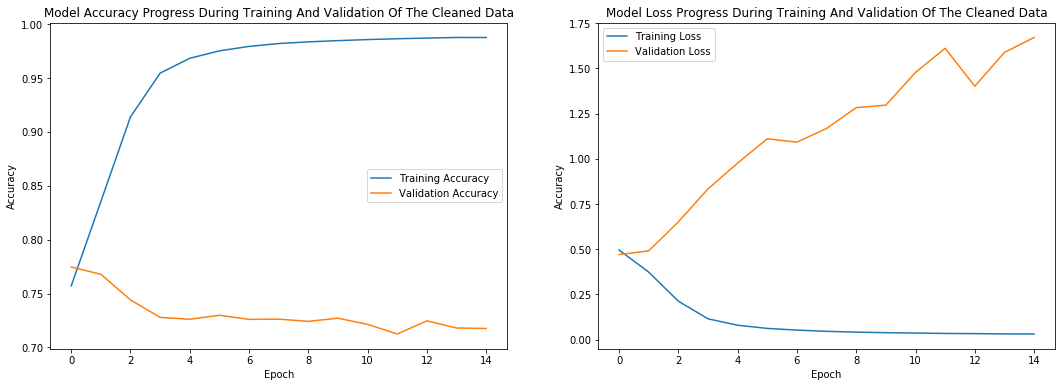

In [0]:
#Cleaned Data
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Training And Validation Of The Cleaned Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Progress During Training And Validation Of The Cleaned Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

#### Plot of Partially Cleaned Data accuracy and loss progress during the training and validation.

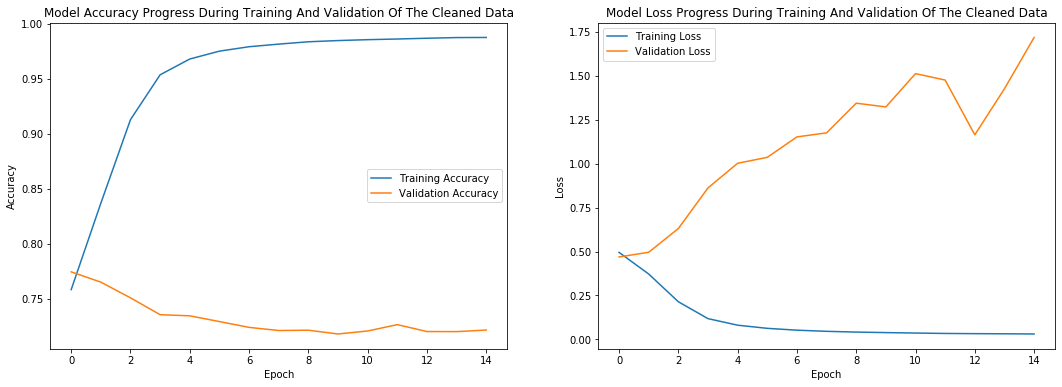

In [0]:
#Partially Cleaned Data
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy Progress During Training And Validation Of The Cleaned Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss Progress During Training And Validation Of The Cleaned Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

As seen in the plot above, the training accuracy of the partially cleaned data is similar to the totally cleaned data. It had a high increase in the first four epochs, going from 0,7582 on the first epoch to 0.9679 on the fifth epoch. It increased slowly until the last epoch, ending with 0.9874. 
The validation accuracy of the partially cleaned data on the contrary to the other model had a high decrease until the seventh epoch. Then the validation went up until epoch 11 and decreased slowly once more.

#### Comparison between both models accuracy and loss

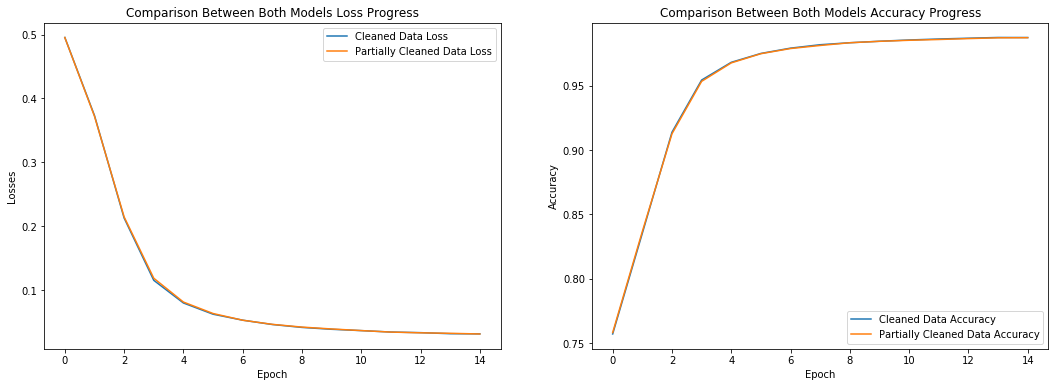

In [0]:
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history2.history['loss'])
plt.title('Comparison Between Both Models Loss Progress')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend(['Cleaned Data Loss', 'Partially Cleaned Data Loss'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history2.history['accuracy'])
plt.title('Comparison Between Both Models Accuracy Progress')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Cleaned Data Accuracy', 'Partially Cleaned Data Accuracy'])
plt.show()

For both models, the training accuracy and the loss were pretty similar.

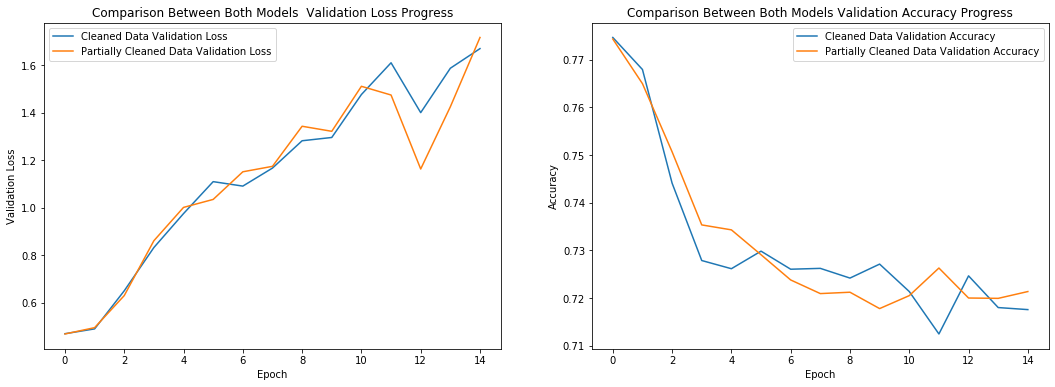

In [0]:
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'])
plt.plot(history2.history['val_loss'])
plt.title('Comparison Between Both Models  Validation Loss Progress')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Cleaned Data Validation Loss', 'Partially Cleaned Data Validation Loss'])

plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Comparison Between Both Models Validation Accuracy Progress')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Cleaned Data Validation Accuracy', 'Partially Cleaned Data Validation Accuracy'])
plt.show()

### Predictions

#### Predictions on the Data Clean Model

In [0]:
positive_text = 'you are so funny'
positive_text = tokenizer_data_clean.encode(positive_text)
positive_text

[4005, 13267, 5385, 706]

In [0]:
dcnn(np.array([positive_text]), training=False).numpy()

array([[0.9829495]], dtype=float32)

In [0]:
negative_text = 'i hate you'
negative_text = tokenizer_data_clean.encode(negative_text)
negative_text

[299, 64, 3425]

In [0]:
dcnn(np.array([negative_text]), training=False).numpy()

array([[0.00059492]], dtype=float32)

#### Predictions on the Data Partially Cleaned Model

In [0]:
positive_text2 = 'you are so funny'
positive_text2 = tokenizer_dataPartially_clean.encode(positive_text2)
positive_text2

[4005, 13267, 5385, 706]

In [0]:
dcnn2(np.array([positive_text2]), training=False).numpy()

array([[0.99990845]], dtype=float32)

In [0]:
negative_text2 = 'i hate you'
negative_text2 = tokenizer_dataPartially_clean.encode(negative_text2)
negative_text2

[299, 64, 3425]

In [0]:
dcnn2(np.array([negative_text2]), training=False).numpy()

array([[1.0466613e-06]], dtype=float32)